In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0

from utils import extract_cid_results, gen_conv_list, \
                calc_time_avs_ind_samples, calc_moments, calc_av_along_axes
from utils_plot import plot_moments

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [2]:
extract = False
calc_time_av = False
verbose = True
save_figs = True

use_sd = False

nbits = 5
cg = 4

if use_sd:
    nexp = 10
    data_suffix = 'sd'
    output_suffix=f'_nb{nbits}cg{cg}'
    uncertainty_multiplier = 20
    L_list = [512]
    act_exclude_dict = {512: []}
else:
    nexp = 5
    data_suffix = ''
    output_suffix=f'_nb{nbits}cg{cg}'
    uncertainty_multiplier = 20
    L_list = [512, 1024, 2048]
    act_exclude_dict = {512: [0.02, 0.0225], 1024: [], 2048: [0.0225]}

figs_save_path = f'data\\nematic\\figs\\{data_suffix}{output_suffix[1:]}'
if not os.path.exists(figs_save_path): os.makedirs(figs_save_path )

act_dict = {}
conv_dict = {}
cid_dict = {}
cid_shuffle_dict = {}
frac_dict = {}
cid_time_av_dict = {}
cid_shuffle_time_av_dict = {}
frac_time_av_dict = {}

cid_var_dict = {}
cid_varper_dict = {}
div_var_dict = {}
div_varper_dict = {}

for LX in L_list:

    base_path = f'Z:\\cid\\na{LX}{data_suffix}'
    save_path = f'data\\nematic\\na{LX}{data_suffix}'

    if not os.path.exists(save_path):
        os.makedirs(save_path)


    info_dict = {'base_path': base_path,
                'save_path': save_path,
                'output_suffix': output_suffix,
                'act_exclude_list': act_exclude_dict[LX],
                'LX': LX,
                'nexp': nexp,}

    if extract:
        conv_list = np.load(os.path.join(save_path, f'conv_list.npy'), allow_pickle=True)
        extract_cid_results(info_dict, verbose=True)
        gen_conv_list(conv_list, output_suffix, save_path)

    with open(os.path.join(save_path, f'cid_params{output_suffix}.pkl'), 'rb') as f:
                    cid_params = pkl.load(f)

    ncubes = cid_params['ncubes']
    nframes_per_cube = cid_params['nframes_per_cube']
    npartitions = cid_params['npartitions']

    data_npz = np.load(os.path.join(save_path, f'cid_data{output_suffix}.npz'), allow_pickle=True)
    cid_arr = data_npz['cid']
    cid_shuffle_arr = data_npz['cid_shuffle']
    cid_frac_arr = data_npz['cid_frac']
    act_dict[LX] = data_npz['act_list']
    conv_dict[LX] = np.load(os.path.join(save_path, f'conv_list_cubes{output_suffix}.npy'), allow_pickle=True)

    if calc_time_av:
        cid_time_av, cid_var, cid_var_per_exp = calc_time_avs_ind_samples(cid_arr[:,:,:,:,0], conv_dict[LX], unc_multiplier=uncertainty_multiplier)
        cid_shuffle_time_av, cid_shuffle_var, cid_shuffle_var_per_exp = calc_time_avs_ind_samples(cid_shuffle_arr[:,:,:,:,0], conv_dict[LX], unc_multiplier=uncertainty_multiplier)
        cid_frac_time_av, cid_frac_var, cid_frac_var_per_exp = calc_time_avs_ind_samples(cid_frac_arr[:,:,:,:,0], conv_dict[LX], unc_multiplier=uncertainty_multiplier)

        np.savez_compressed(os.path.join(save_path, f'cid_time_av{output_suffix}.npz'),
                            cid_time_av=cid_time_av,
                            cid_var=cid_var,
                            cid_var_per_exp=cid_var_per_exp,
                            cid_shuffle_time_av=cid_shuffle_time_av,
                            cid_shuffle_var=cid_shuffle_var,
                            cid_shuffle_var_per_exp=cid_shuffle_var_per_exp,
                            cid_frac_time_av=cid_frac_time_av,
                            cid_frac_var=cid_frac_var,
                            cid_frac_var_per_exp=cid_frac_var_per_exp,
                            act_list=act_dict[LX],
                            conv_list=conv_dict[LX]
                            )
    else:
        time_av_npz = np.load(os.path.join(save_path, f'cid_time_av{output_suffix}.npz'), allow_pickle=True)
        cid_time_av = time_av_npz['cid_time_av']
        cid_shuffle_time_av = time_av_npz['cid_shuffle_time_av']
        cid_frac_time_av = time_av_npz['cid_frac_time_av']
        cid_var = time_av_npz['cid_var']
        cid_var_per_exp = time_av_npz['cid_var_per_exp']
        cid_frac_var = time_av_npz['cid_frac_var']
        cid_frac_var_per_exp = time_av_npz['cid_frac_var_per_exp']
        

    cid_dict[LX] = cid_arr
    cid_shuffle_dict[LX] = cid_shuffle_arr
    frac_dict[LX] = cid_frac_arr
    cid_time_av_dict[LX] = cid_time_av
    cid_shuffle_time_av_dict[LX] = cid_shuffle_time_av
    frac_time_av_dict[LX] = cid_frac_time_av
    cid_var_dict[LX] = cid_var
    cid_varper_dict[LX] = cid_var_per_exp
    div_var_dict[LX] = cid_frac_var
    div_varper_dict[LX] = cid_frac_var_per_exp

In [ ]:
plot_cid = True
convert_xvals = False
acts_to_exclude = [] # [0.0225]
act_max = 0.04
ninfo=500
LX=1024

if plot_cid:
  av_vals = calc_av_along_axes(cid_dict[LX][..., 0],axes_to_average=(1,-1),  unc_multiplier=uncertainty_multiplier)
else:
  av_vals = calc_av_along_axes(1-frac_dict[LX][..., 0],axes_to_average=(1,-1),  unc_multiplier=uncertainty_multiplier)

fig, ax = plt.subplots()
xvals = np.arange(ncubes) * nframes_per_cube * ninfo if convert_xvals else np.arange(ncubes)
for i, act in enumerate(act_dict[LX]):
    if act in acts_to_exclude:
        continue
    if act > act_max:
        continue
    ax.errorbar(xvals, av_vals[:,i,0], yerr=av_vals[:,i,1], lw=1,\
                elinewidth=1.3, fmt='o-', alpha=.4,
                label=rf'$\zeta=$ {act:.4f}')

ax.set_xlabel('Timestep')
ax.set_ylabel('CID' if plot_cid else r'$\mathcal{D}$')
ylims = ax.get_ylim()
ax.set_ylim(ylims[0], ylims[1]*1.05)
ax.legend(loc='upper left', ncol=4)

if save_figs:
  savename = 'cid' if plot_cid else 'div'
  #fig.savefig(os.path.join(figs_save_path, f'{savename}_time{output_suffix}.pdf') ,bbox_inches='tight', dpi=620, pad_inches=.05)

In [26]:
shape = (5,2,9, 11,5, 12)
axes_to_average = (0, -2, -1)
axes_to_average = tuple(i%len(shape) for i in axes_to_average)

# modify the line below so that i is relative to axes_to_average, ie -1 refers to the last axis of shape
shape_new = tuple(dim for i, dim in enumerate(shape) if i not in axes_to_average) + (2,)
x=np.ones(shape_new)
x.shape

(2, 9, 11, 2)

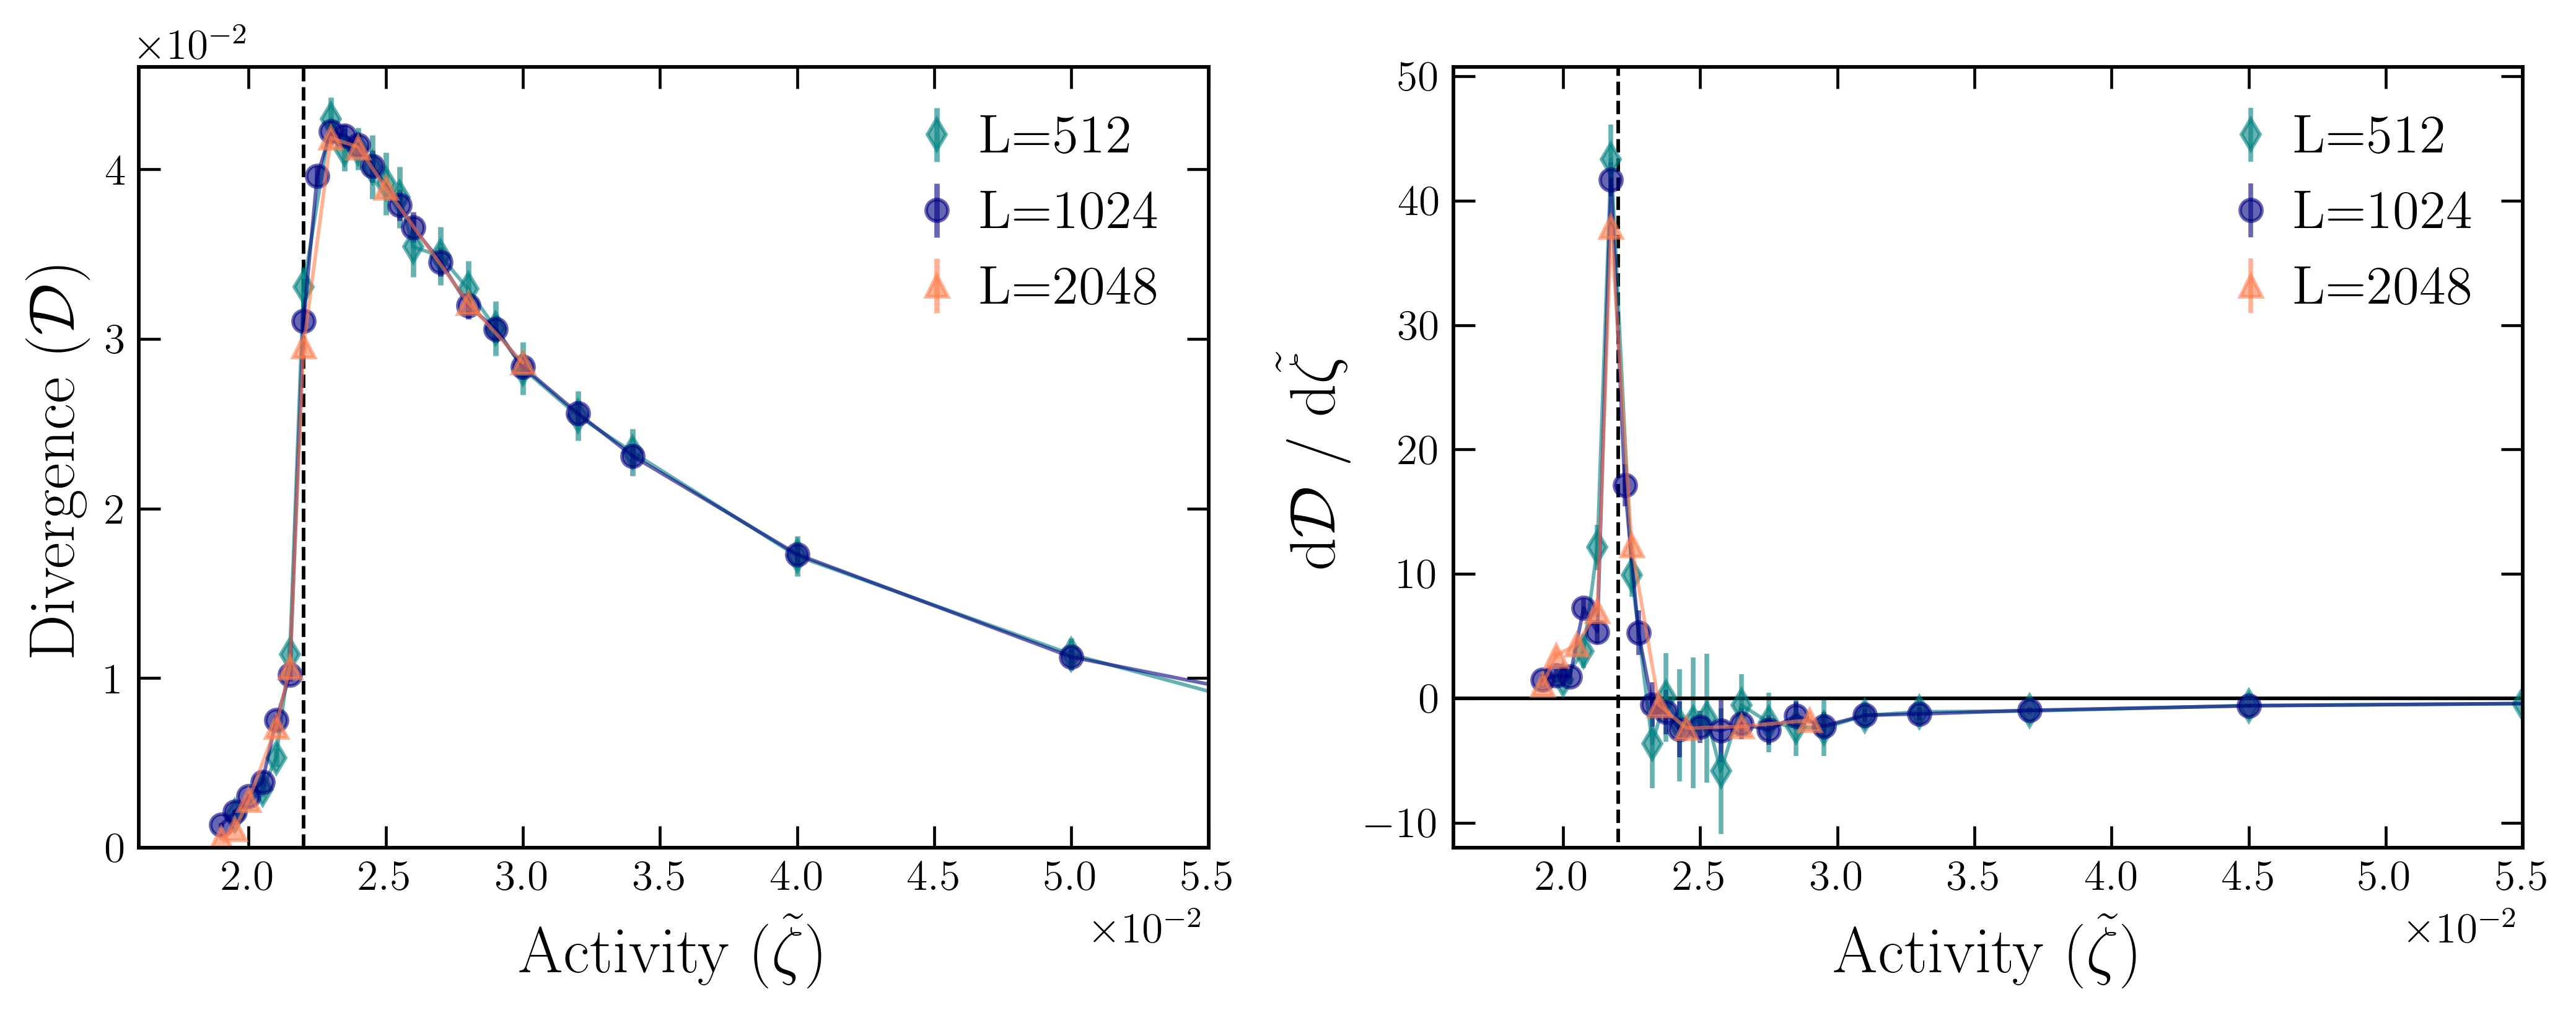

In [61]:

fig, ax0 = plt.subplots(ncols=2, figsize=(10,4))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax = ax0[0]
axx = ax0[1]

plot_div = True
plot_abs = False

xlim = (0.016, 0.055)
ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    frac_diff = np.diff(1 - cid_frac_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_frac_err = np.sqrt(cid_frac_time_av[:, 1][1:]**2 + cid_frac_time_av[:,1][:-1]**2) / act_diff

    yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]
    frac_yvals = np.abs(deriv_frac) if plot_abs else deriv_frac

    ax.errorbar(act_list, yvals, yerr=cid_frac_time_av[:,1], fmt=marker_shape[i], lw=1, elinewidth=1.5, label=f'L={LX}', alpha=.6)
    axx.errorbar(act_diff_tot, frac_yvals, yerr=deriv_frac_err, fmt=marker_shape[i], lw=1, elinewidth=1.3, label=f'L={LX}',alpha=.6)

    ymin = min(ymin, np.nanmin(frac_yvals - deriv_frac_err))
    ymax = max(ymax, np.nanmax(frac_yvals + deriv_frac_err))

ax.vlines(0.022, 0, np.nanmax(yvals*1.1), color='k', linestyle='--', lw=1, zorder=-5)
ax.set_ylim(0, np.nanmax(yvals*1.1))

ylabel = r'Divergence ($\mathcal{D}$)' if plot_div else r'CID/CID$_\mathrm{shuffle}$)'
ax.set_ylabel(ylabel) #
ax.legend()

axx.vlines(0.022, ymin*1.2, ymax*1.2, color='k', linestyle='--', lw=1,)
axx.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
axx.set_ylim(ymin*1.1, ymax*1.1)
axx.set_ylabel(r'd$\mathcal{D}$ / d$\tilde{\zeta}$')
axx.legend(ncols=1, loc='upper right')

for i in range(2):
    ax0[i].set_xlim(xlim)
  #  ax0[i].vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1,)
    ax0[i].set_xlabel(r'Activity ($\tilde{\zeta}$)')
#axx.set_xlim(xmax=0.045)
if save_figs:
  fig.savefig(os.path.join(figs_save_path, f'div_ddiv.pdf') ,bbox_inches='tight', dpi=620, pad_inches=.05)

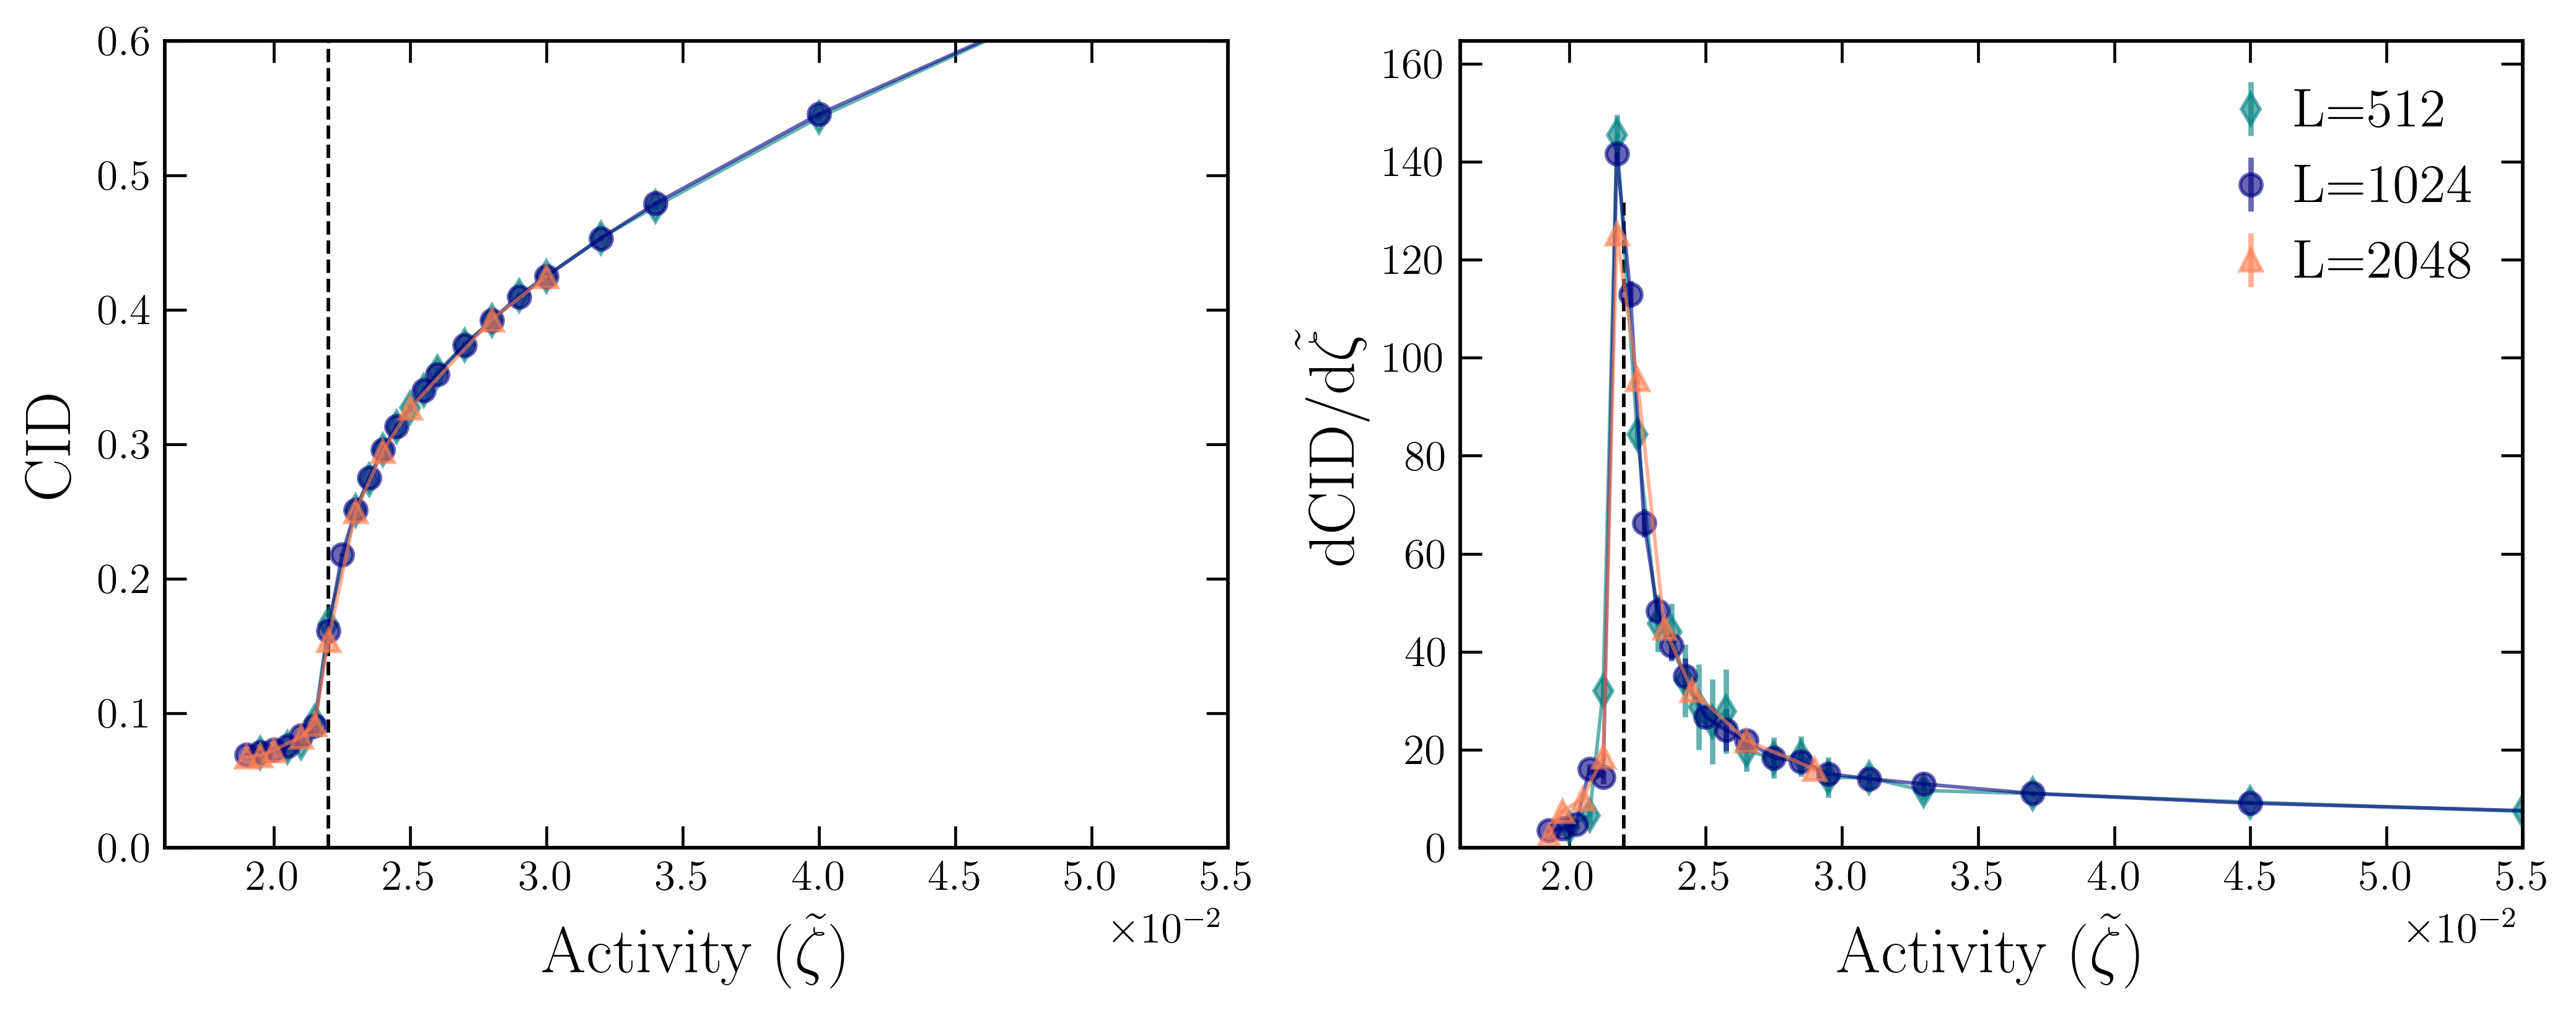

In [62]:
### Plot cid_av vs activity for different system sizes
fig, ax0 = plt.subplots(ncols=2, figsize=(10,4))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

xlim = (0.016, 0.055)
ax = ax0[0]
axx = ax0[1]

ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    cid_diff = np.diff(cid_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    ymin = min(ymin, np.nanmin(deriv_cid - deriv_cid_err))
    ymax = max(ymax, np.nanmax(deriv_cid + deriv_cid_err))

    ax.errorbar(act_list, cid_time_av[:,0], yerr=cid_time_av[:,1], fmt=marker_shape[i], lw=1, label=f'L={LX}', elinewidth=1.5,  alpha=.6)
    axx.errorbar(act_diff_tot, deriv_cid, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', lw=1, elinewidth=1.5, alpha=.6)

for i in range(2):
    ax0[i].set_xlim(xlim)
    ax0[i].vlines(0.022, 0, np.nanmax(deriv_cid*1.05), color='k', linestyle='--', lw=1,)
    ax0[i].set_xlabel(r'Activity ($\tilde{\zeta}$)')

ax.set_ylim(0, 0.6)
ax.set_ylabel(r'CID')
axx.set_ylim(0, np.nanmax(ymax)*1.1)
axx.set_ylabel(r'dCID/d$\tilde{\zeta}$')
axx.legend(ncols=1, loc='upper right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'cid_dcid.pdf'), \
                bbox_inches='tight', dpi=620, pad_inches=.05)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_16208\377182572.py:26: RuntimeWarning: Mean of empty slice
  varper_av = np.nanmean(varper, axis=1)


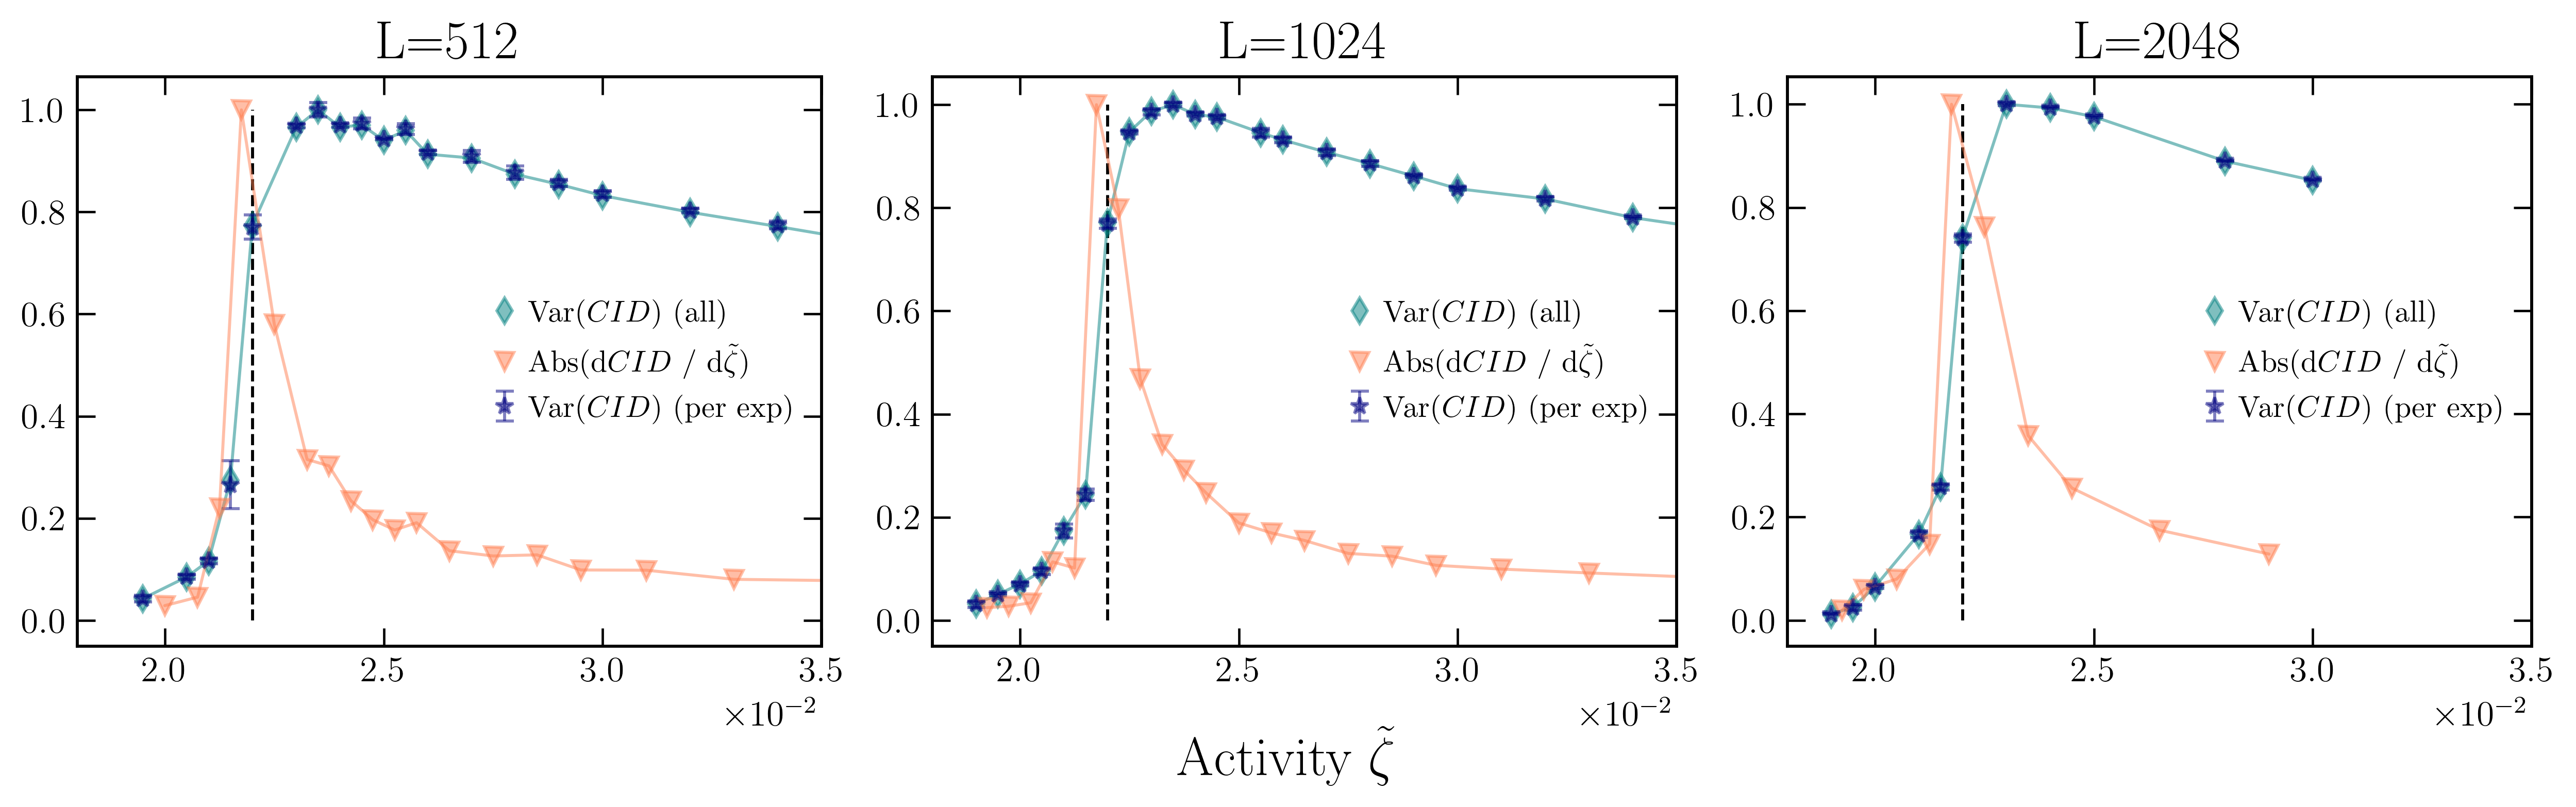

In [63]:
### Plot
fig, ax0 = plt.subplots(ncols=3, figsize=(12,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

plot_cid = True
plot_abs = True

xlim = (0.016, 0.055)
ymin, ymax = 0, 0
for ax in ax0[:]:
  LX = L_list[ax0.tolist().index(ax)]
  act_list = act_dict[LX]
  conv_list = conv_dict[LX]

  cid_time_av = cid_time_av_dict[LX]
  cid_frac_time_av = frac_time_av_dict[LX]

  act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
  act_diff_tot = np.array(act_list[:-1]) + act_diff/2

  cid_diff = np.diff(cid_time_av[:, 0]) #
  deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
  deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

  varall, varper = cid_var_dict[LX], cid_varper_dict[LX]
  varper_av = np.nanmean(varper, axis=1)
  varper_sem = np.nanstd(varper, axis=1) / np.sqrt(varper.shape[1])


  dcid_vals = np.abs(deriv_cid / np.nanmax(deriv_cid)) if plot_abs else deriv_cid / np.nanmax(deriv_cid)

  ax.plot(act_list, varall / np.nanmax(varall), label=r'$\mathrm{Var} (CID)$ (all)', marker='d', lw=1, alpha=.5)
  ax.errorbar(act_list, varper_av / np.nanmax(varper_av), yerr=varper_sem / np.nanmax(varper_av), fmt='*', alpha=0.5, capsize=3, label=r'$\mathrm{Var} (CID)$ (per exp)', lw=1
              )
  ax.plot(act_diff_tot, dcid_vals, marker='v', label=r'Abs(d$CID$ / d$\tilde{\zeta}$)', lw=1, alpha=.5)

  ax.set_title(f'L={LX}')
  ax.set_xlim(0.018,0.035)
  ax.vlines(0.022,0,1,color='k', linestyle='--',zorder=-5,lw=1)#label='Transition region')
  ax.legend(fontsize=10)

fig.supxlabel(r'Activity $\tilde{\zeta}$', y=0.08)

if save_figs: 
  figname = 'cid_fluc.pdf'
  fig.savefig(os.path.join(figs_save_path, figname) ,bbox_inches='tight', dpi=620, pad_inches=.05)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_16208\1999536955.py:33: RuntimeWarning: Mean of empty slice
  varper_av = np.nanmean(varper, axis=1)


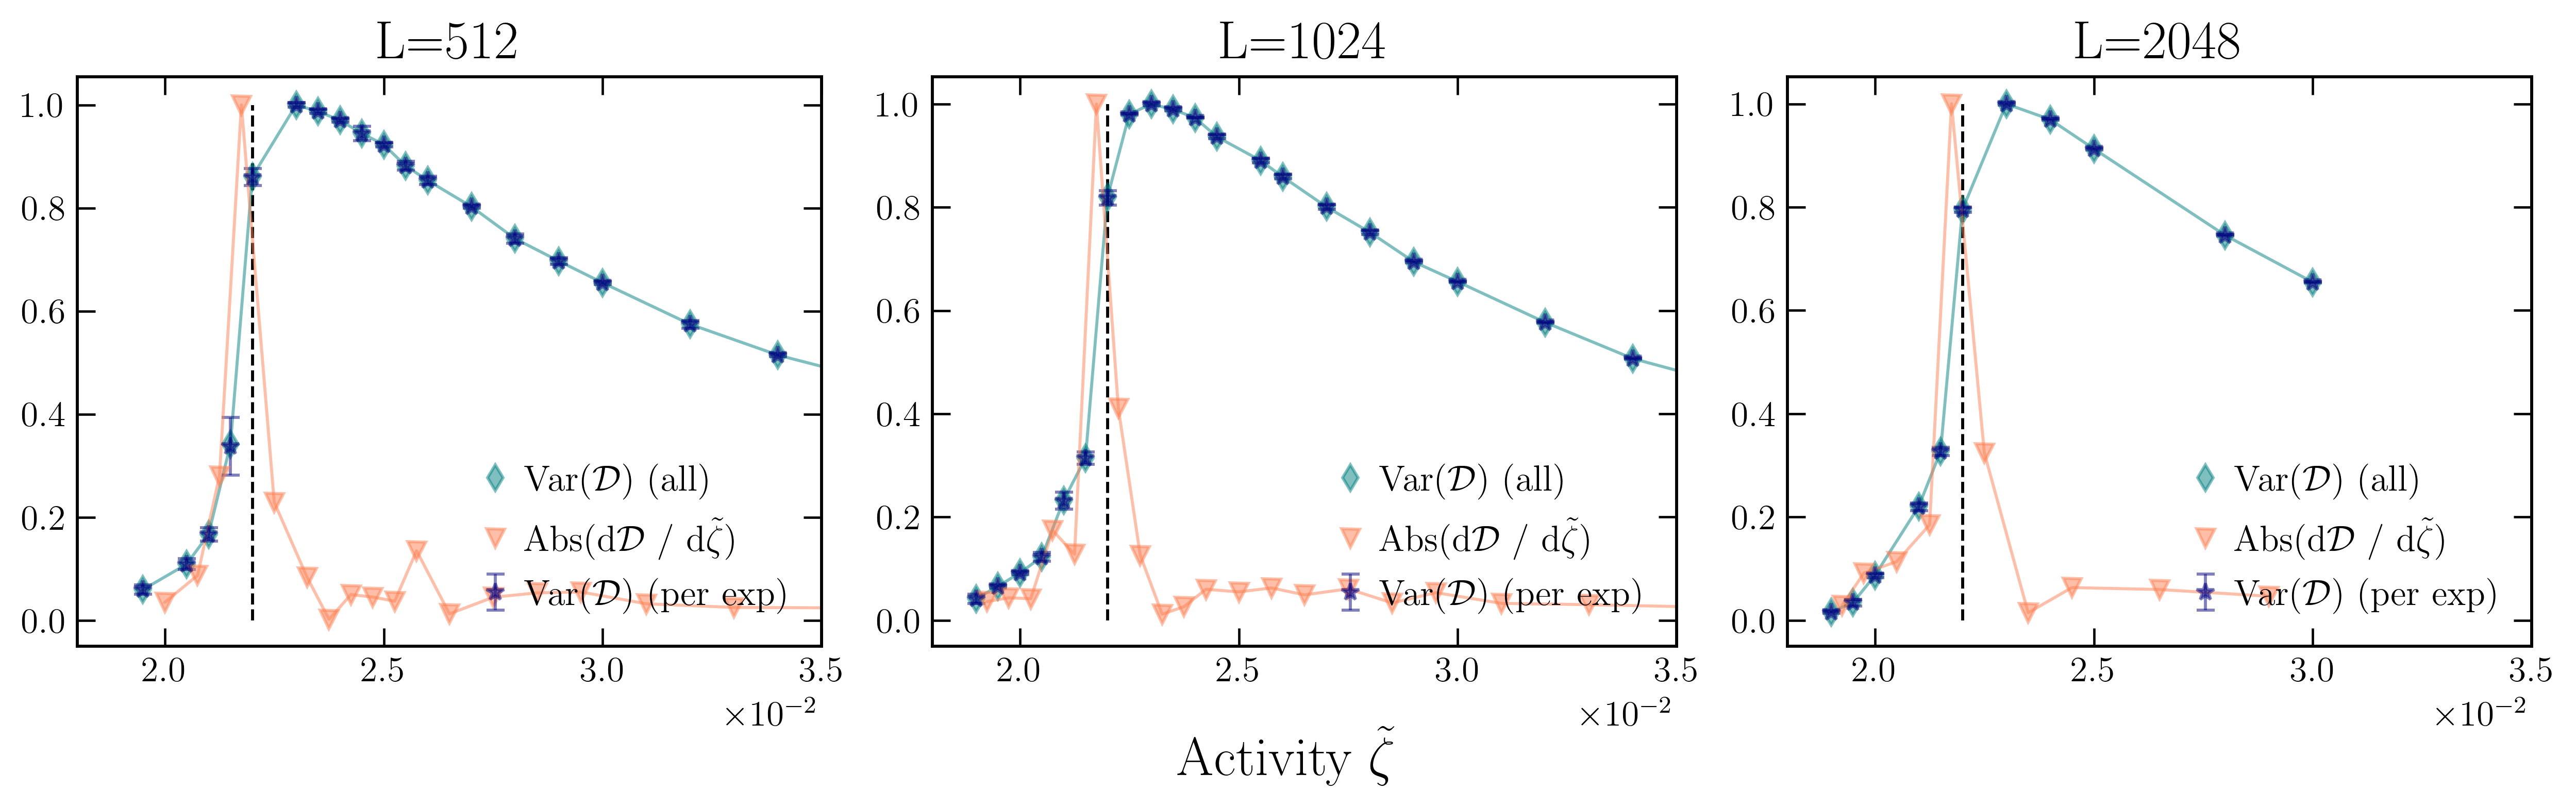

In [64]:
### Plot
fig, ax0 = plt.subplots(ncols=3, figsize=(12,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
#ax = ax0 #[0]
#axx = ax0[1]

plot_cid = False
plot_div = True
plot_abs = True

xlim = (0.016, 0.055)
ymin, ymax = 0, 0
for ax in ax0[:]:
  LX = L_list[ax0.tolist().index(ax)]
  act_list = act_dict[LX]
  conv_list = conv_dict[LX]


  cid_frac_time_av = frac_time_av_dict[LX]

  act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
  act_diff_tot = np.array(act_list[:-1]) + act_diff/2

  frac_diff = np.diff(1 - cid_frac_time_av[:, 0])
  deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
  deriv_frac_err = np.sqrt(cid_frac_time_av[:, 1][1:]**2 + cid_frac_time_av[:,1][:-1]**2) / act_diff
  

  yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]
  frac_yvals = np.abs(deriv_frac) if plot_abs else deriv_frac

  varall, varper = div_var_dict[LX], div_varper_dict[LX]
  varper_av = np.nanmean(varper, axis=1)
  varper_sem = np.nanstd(varper, axis=1) / np.sqrt(varper.shape[1])


  div_vals = np.abs(deriv_frac / np.nanmax(np.abs(deriv_frac))) if plot_abs else deriv_frac / np.nanmax(deriv_frac)

  ax.plot(act_list, varall / np.nanmax(varall), label=r'$\mathrm{Var} (\mathcal{D})$ (all)', marker='d', lw=1, alpha=.5)
  ax.errorbar(act_list, varper_av / np.nanmax(varper_av), yerr=varper_sem / np.nanmax(varper_av), fmt='*', alpha=0.5, capsize=3,\
               label=r'$\mathrm{Var} (\mathcal{D})$ (per exp)', lw=1)
  ax.plot(act_diff_tot, div_vals , marker='v', label=r'Abs(d$\mathcal{D}$ / d$\tilde{\zeta}$)', lw=1, alpha=.5)
  ax.set_title(f'L={LX}')
  ax.set_xlim(0.018,0.035)
  ax.vlines(0.022,0,1,color='k', linestyle='--',zorder=-5,lw=1)#label='Transition region')
  ax.legend(fontsize=12)

ymin = min(ymin, np.nanmin(frac_yvals))
ymax = max(ymax, np.nanmax(frac_yvals))
fig.supxlabel(r'Activity $\tilde{\zeta}$', y=0.08)

if save_figs: 
  figname = 'div_fluc.pdf'
  fig.savefig(os.path.join(figs_save_path, figname) ,bbox_inches='tight', dpi=620, pad_inches=.05)

In [ ]:
moment_dict = {}
div_moment_dict = {}
for LX in L_list:
    moment_dict[LX] = calc_moments(cid_dict[LX][...,0], conv_dict[LX],)
    div_moment_dict[LX] = calc_moments(1-frac_dict[LX][...,0], conv_dict[LX],)

fig, ax = plot_moments(moment_dict, act_dict=act_dict, L_list=L_list[1:], moment_label=r'CID',\
                        plot_binder=False, \
                    savepath=os.path.join(figs_save_path, f'cid_moments{output_suffix}.pdf'))

fig, ax = plot_moments(div_moment_dict, act_dict=act_dict, L_list=L_list[1:], moment_label=r'$\mathcal{D}$',\
                     plot_binder=False, \
                    savepath=os.path.join(figs_save_path, f'div_moments{output_suffix}.pdf'))

#### Single figs:

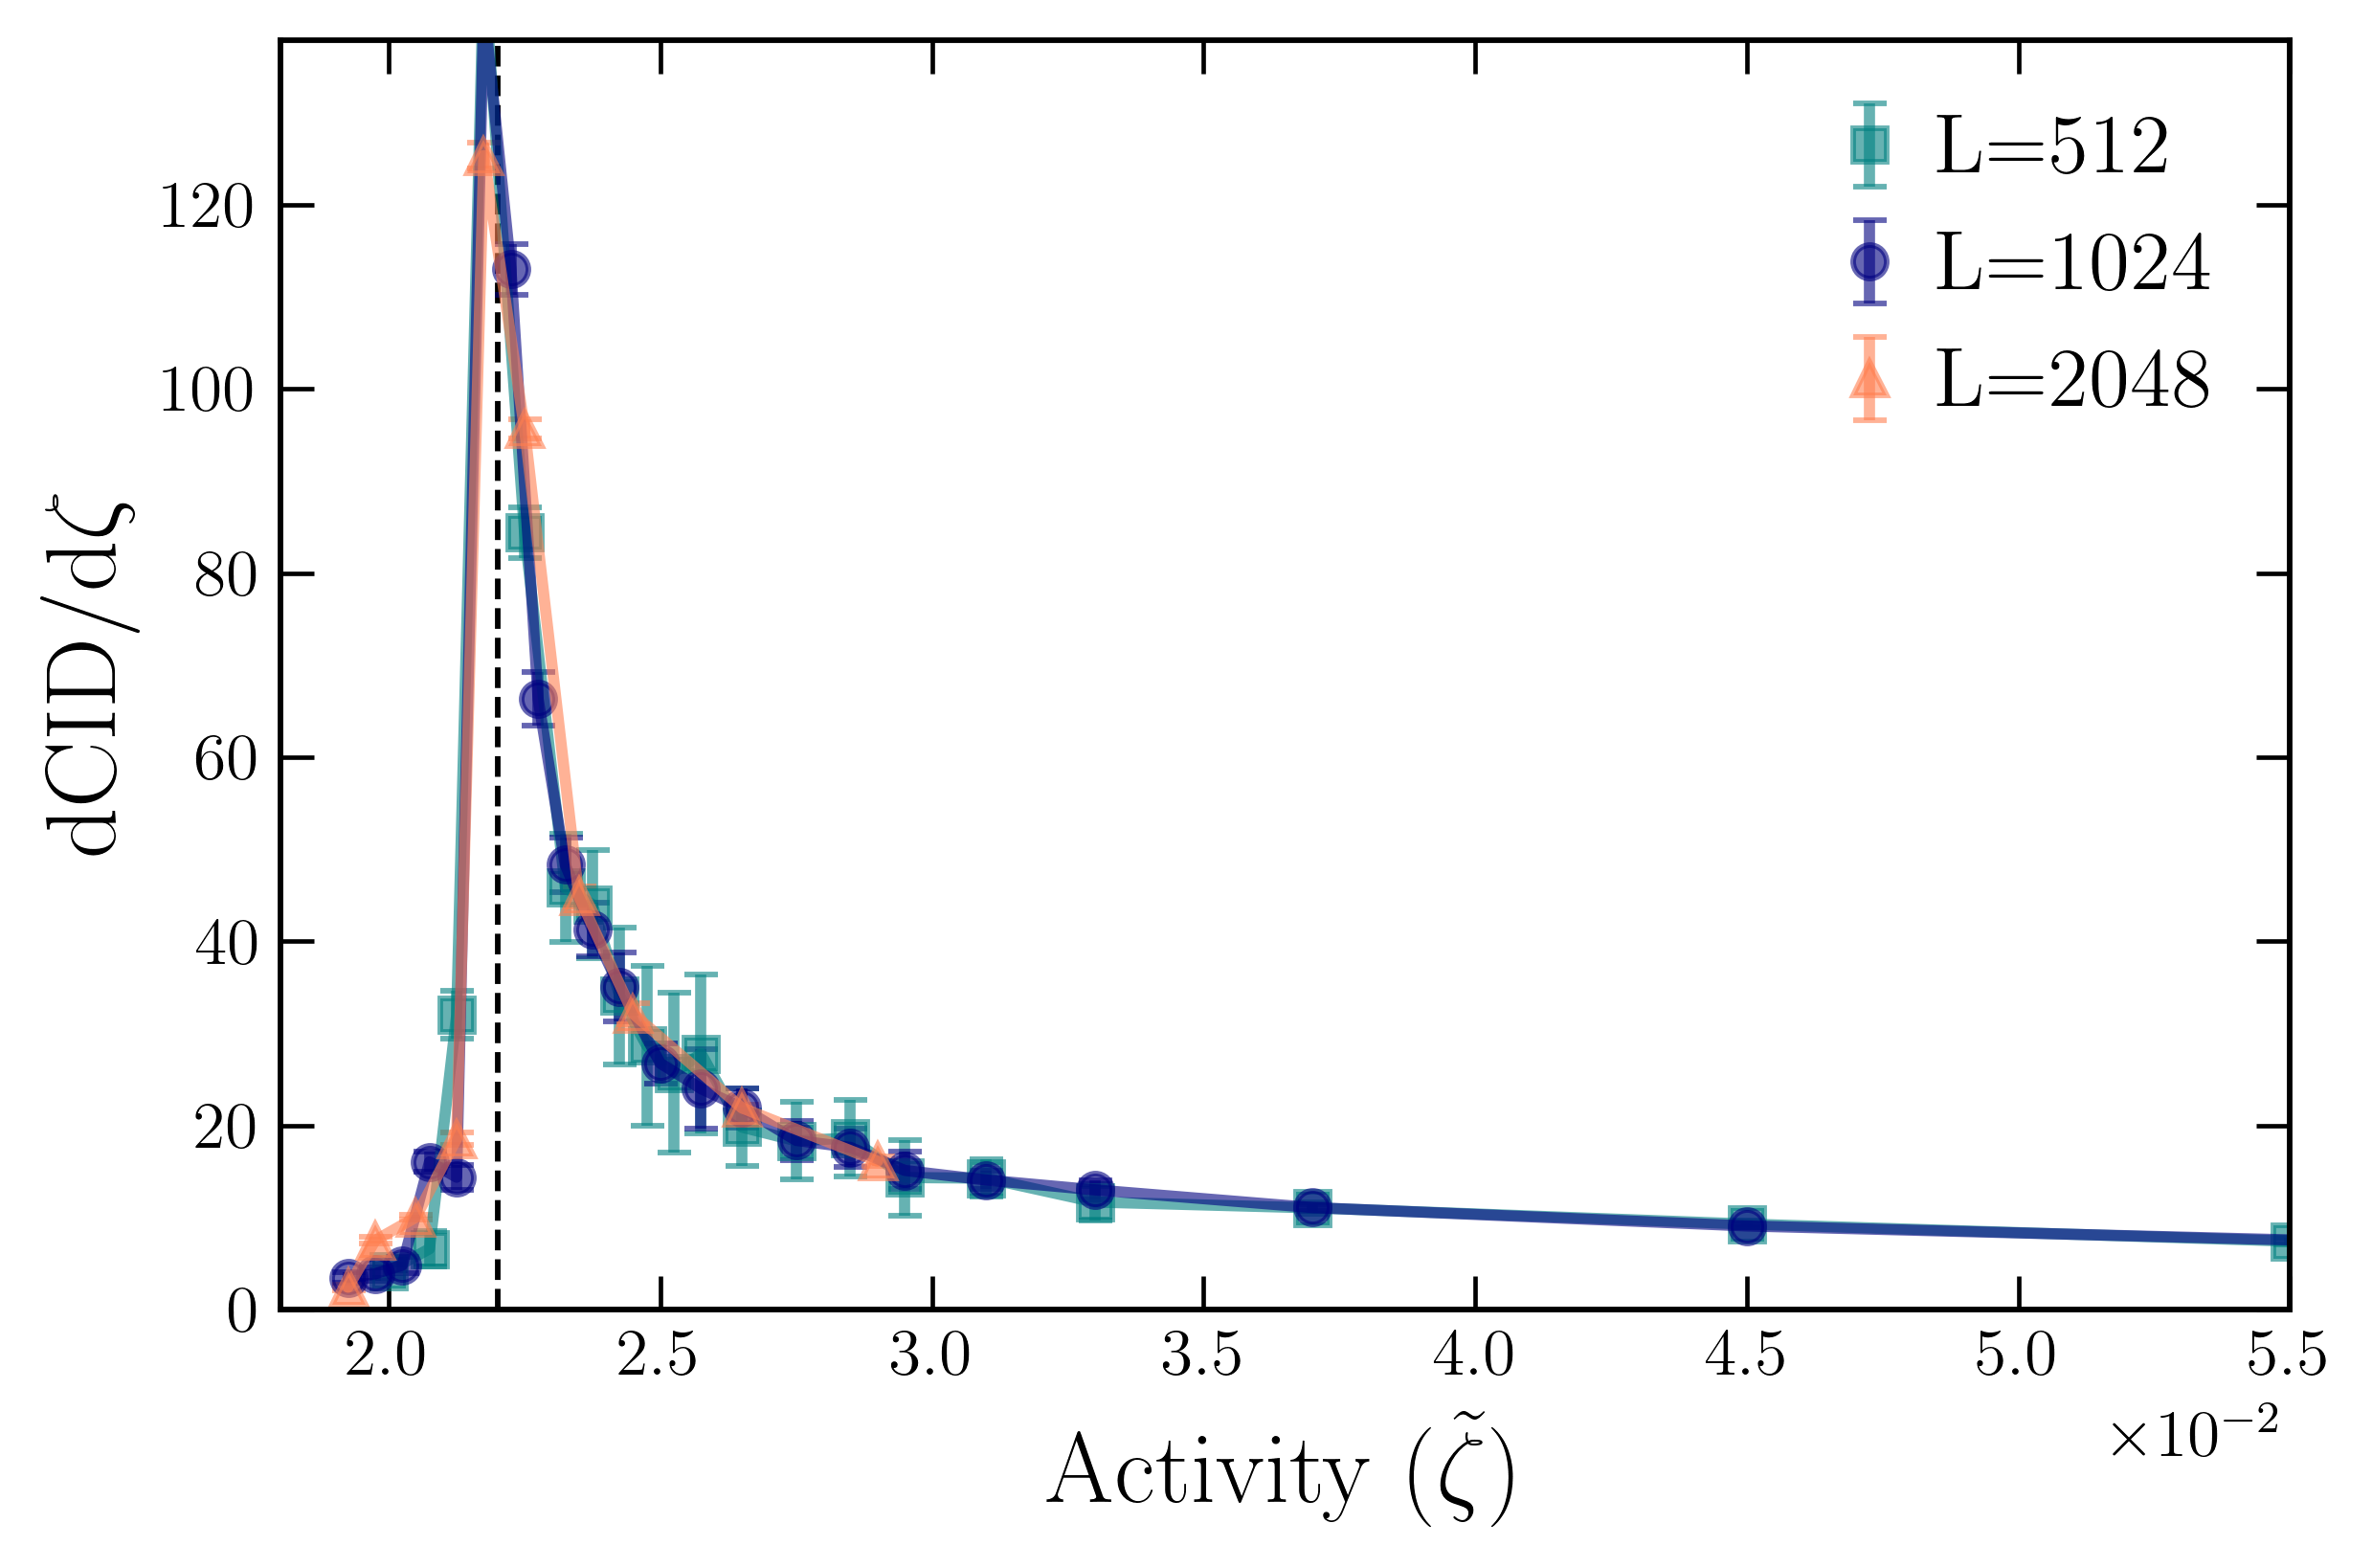

In [65]:
### Plot cid_deriv vs activity for different system sizes
fig, ax = plt.subplots(figsize=(6,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    cid_diff = np.diff(cid_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_cid = cid_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_cid_err = np.sqrt(cid_time_av[:, 1][1:]**2 + cid_time_av[:,1][:-1]**2) / act_diff

    ax.errorbar(act_diff_tot, deriv_cid, yerr=deriv_cid_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

ax.vlines(0.022, 0, np.nanmax(deriv_cid*1.1), color='k', linestyle='--', lw=1, zorder=-5)
ax.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
ax.set_xlim(0.018, 0.055)
ax.set_ylim(ymin=0, ymax=np.nanmax(deriv_cid*1.1))
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ax.set_ylabel(r'dCID/d$\zeta$')
ax.legend(ncols=1, loc='upper right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'dCID.pdf'), bbox_inches='tight', dpi=620, pad_inches=.05)


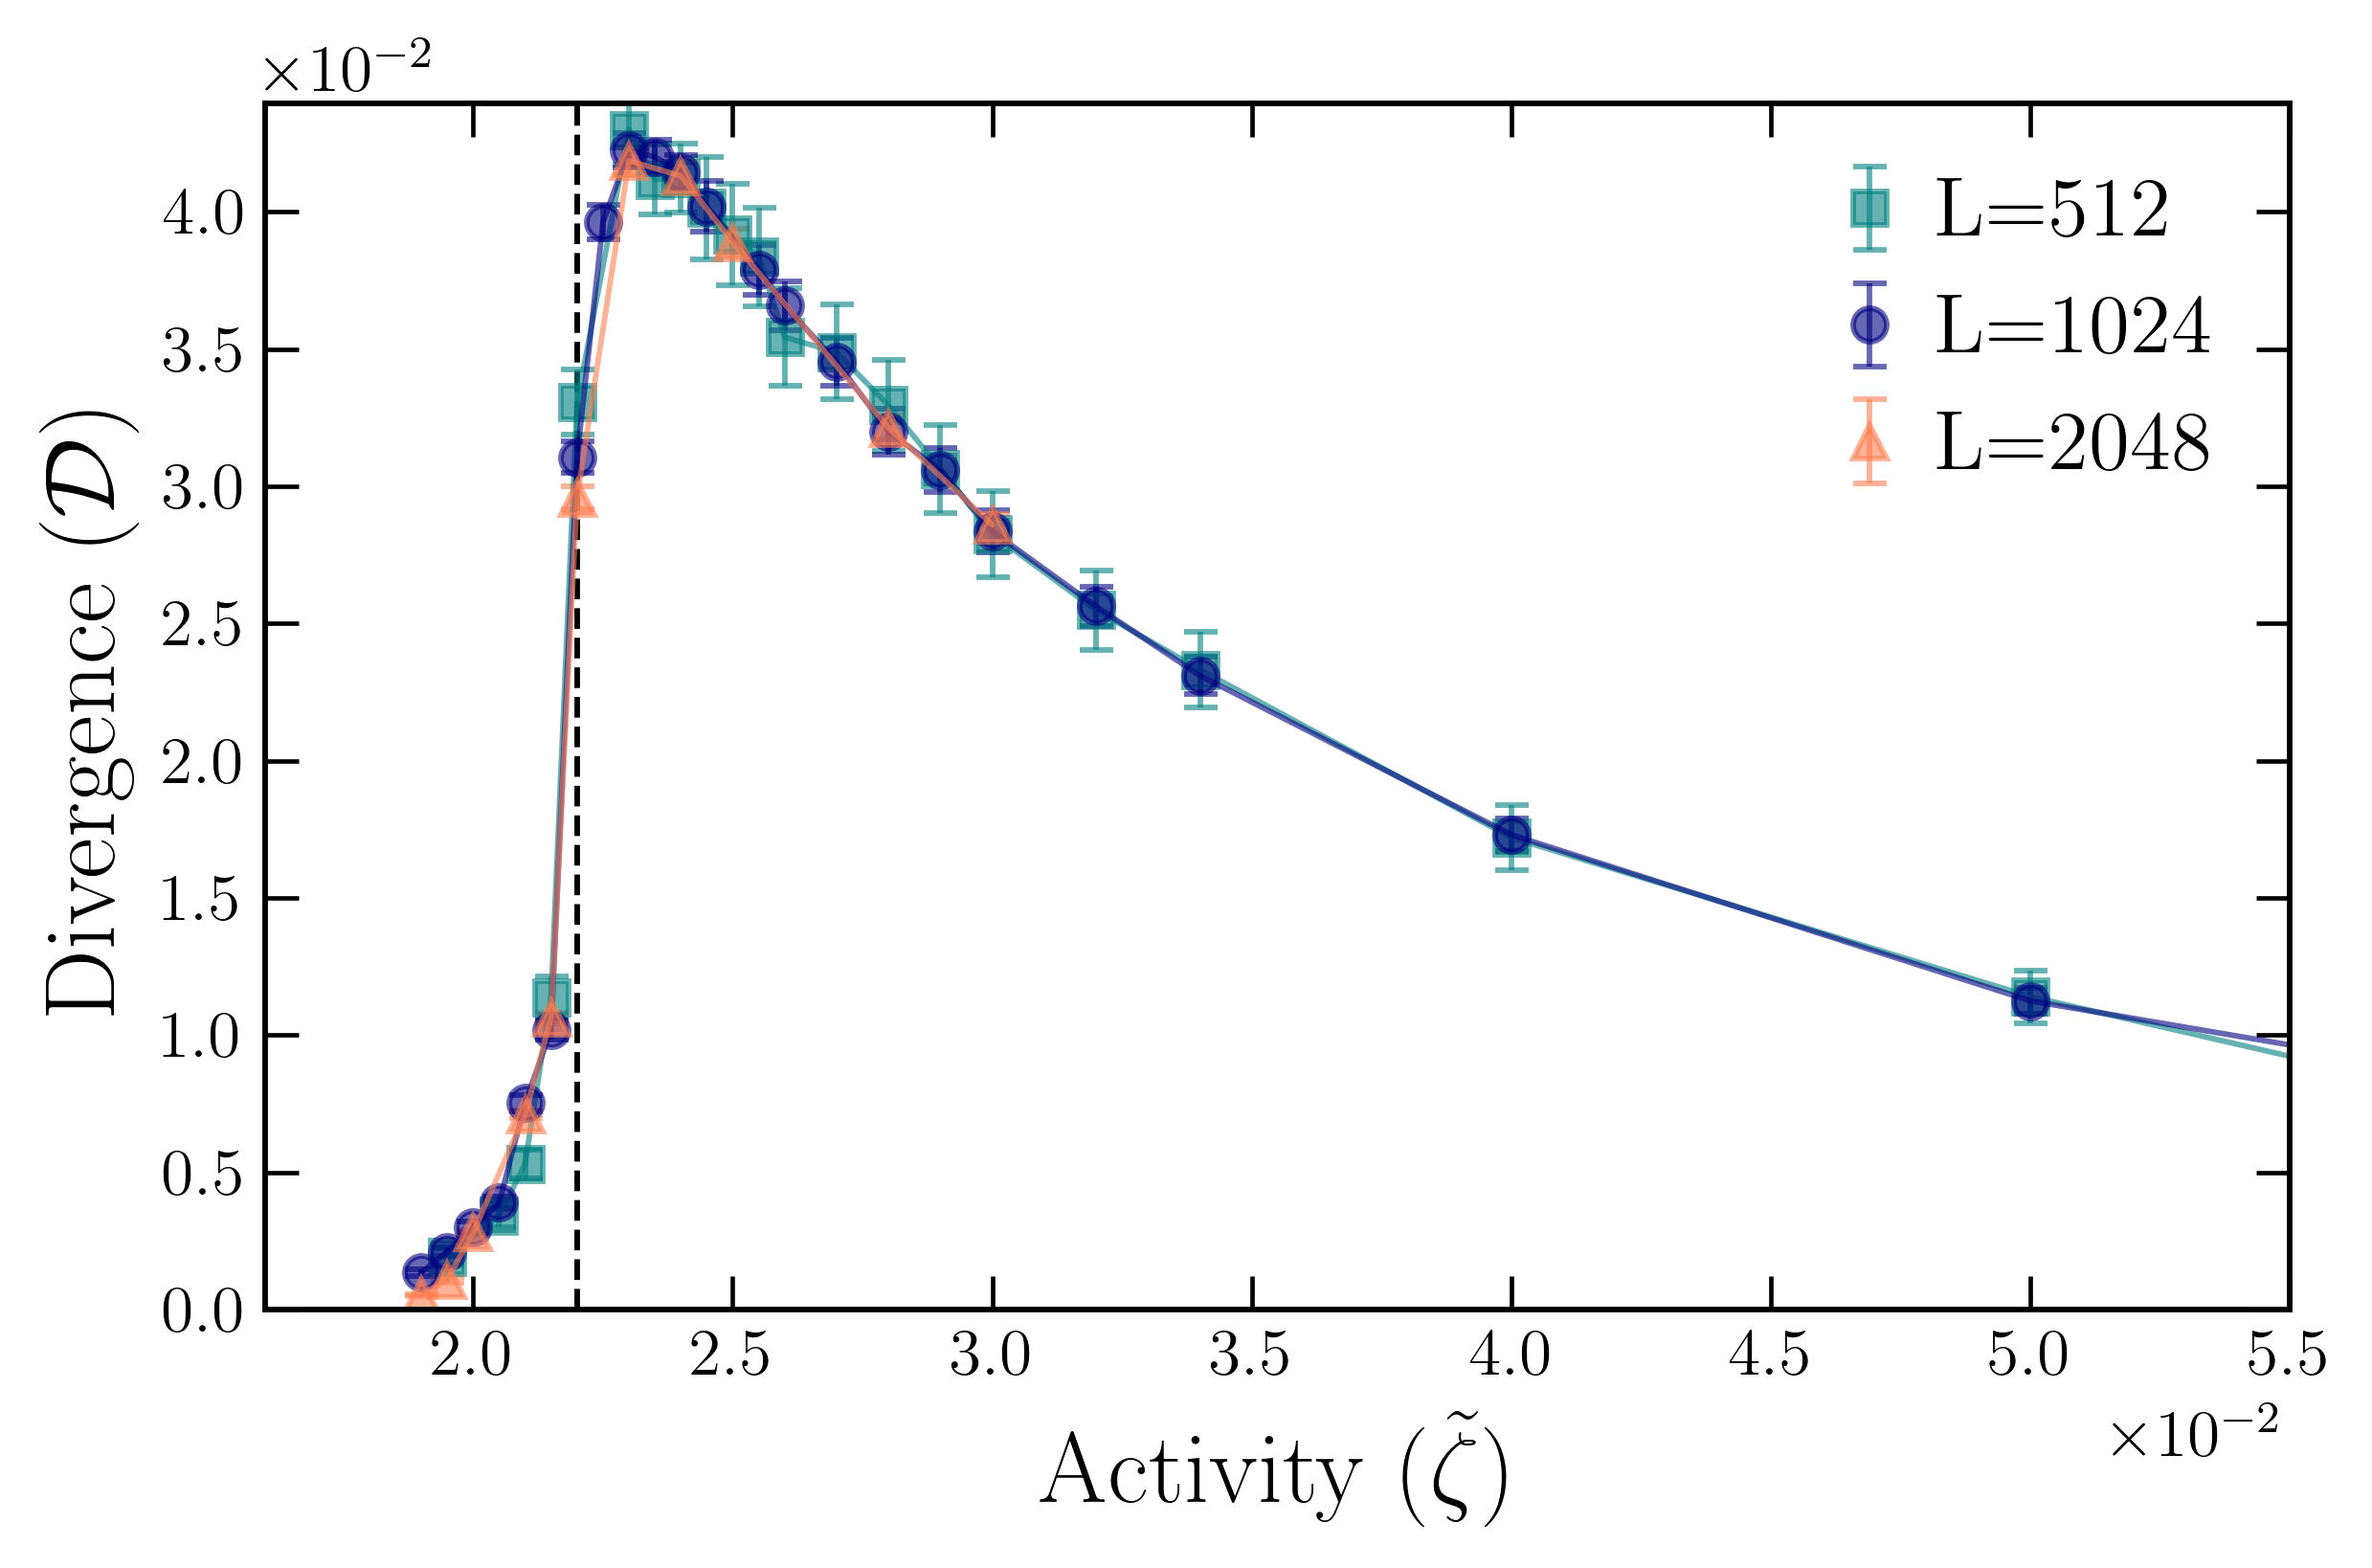

In [66]:
### Plot frac_av vs activity for different system sizes
fig, ax = plt.subplots(figsize=(6,4))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
plot_div = True

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    yvals = 1 - cid_frac_time_av[:,0] if plot_div else cid_frac_time_av[:,0]

    ax.errorbar(act_list, yvals, yerr=cid_frac_time_av[:,1], fmt=marker_shape[i], lw=1, label=f'L={LX}', capsize=3, alpha=.6)

ax.vlines(0.022, 0, np.nanmax(yvals*1.05), color='k', linestyle='--', lw=1, zorder=-5)
ax.set_xlim(0.016, 0.055)
ax.set_ylim(0, np.nanmax(yvals*1.05))
#ax.set_ylim(np.nanmin(cid_frac_time_av[:,0]*0.95), np.nanmax(cid_frac_time_av[:,0]*1.05))
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ylabel = r'Divergence ($\mathcal{D}$)' if plot_div else r'CID/CID$_\mathrm{shuffle}$)'
ax.set_ylabel(ylabel) #CID/CID$_\mathrm{shuffle}
ax.legend()#loc='lower right')

if save_figs:
    fig.savefig(os.path.join(figs_save_path, f'av_div.pdf'),bbox_inches='tight', dpi=620, pad_inches=.05)

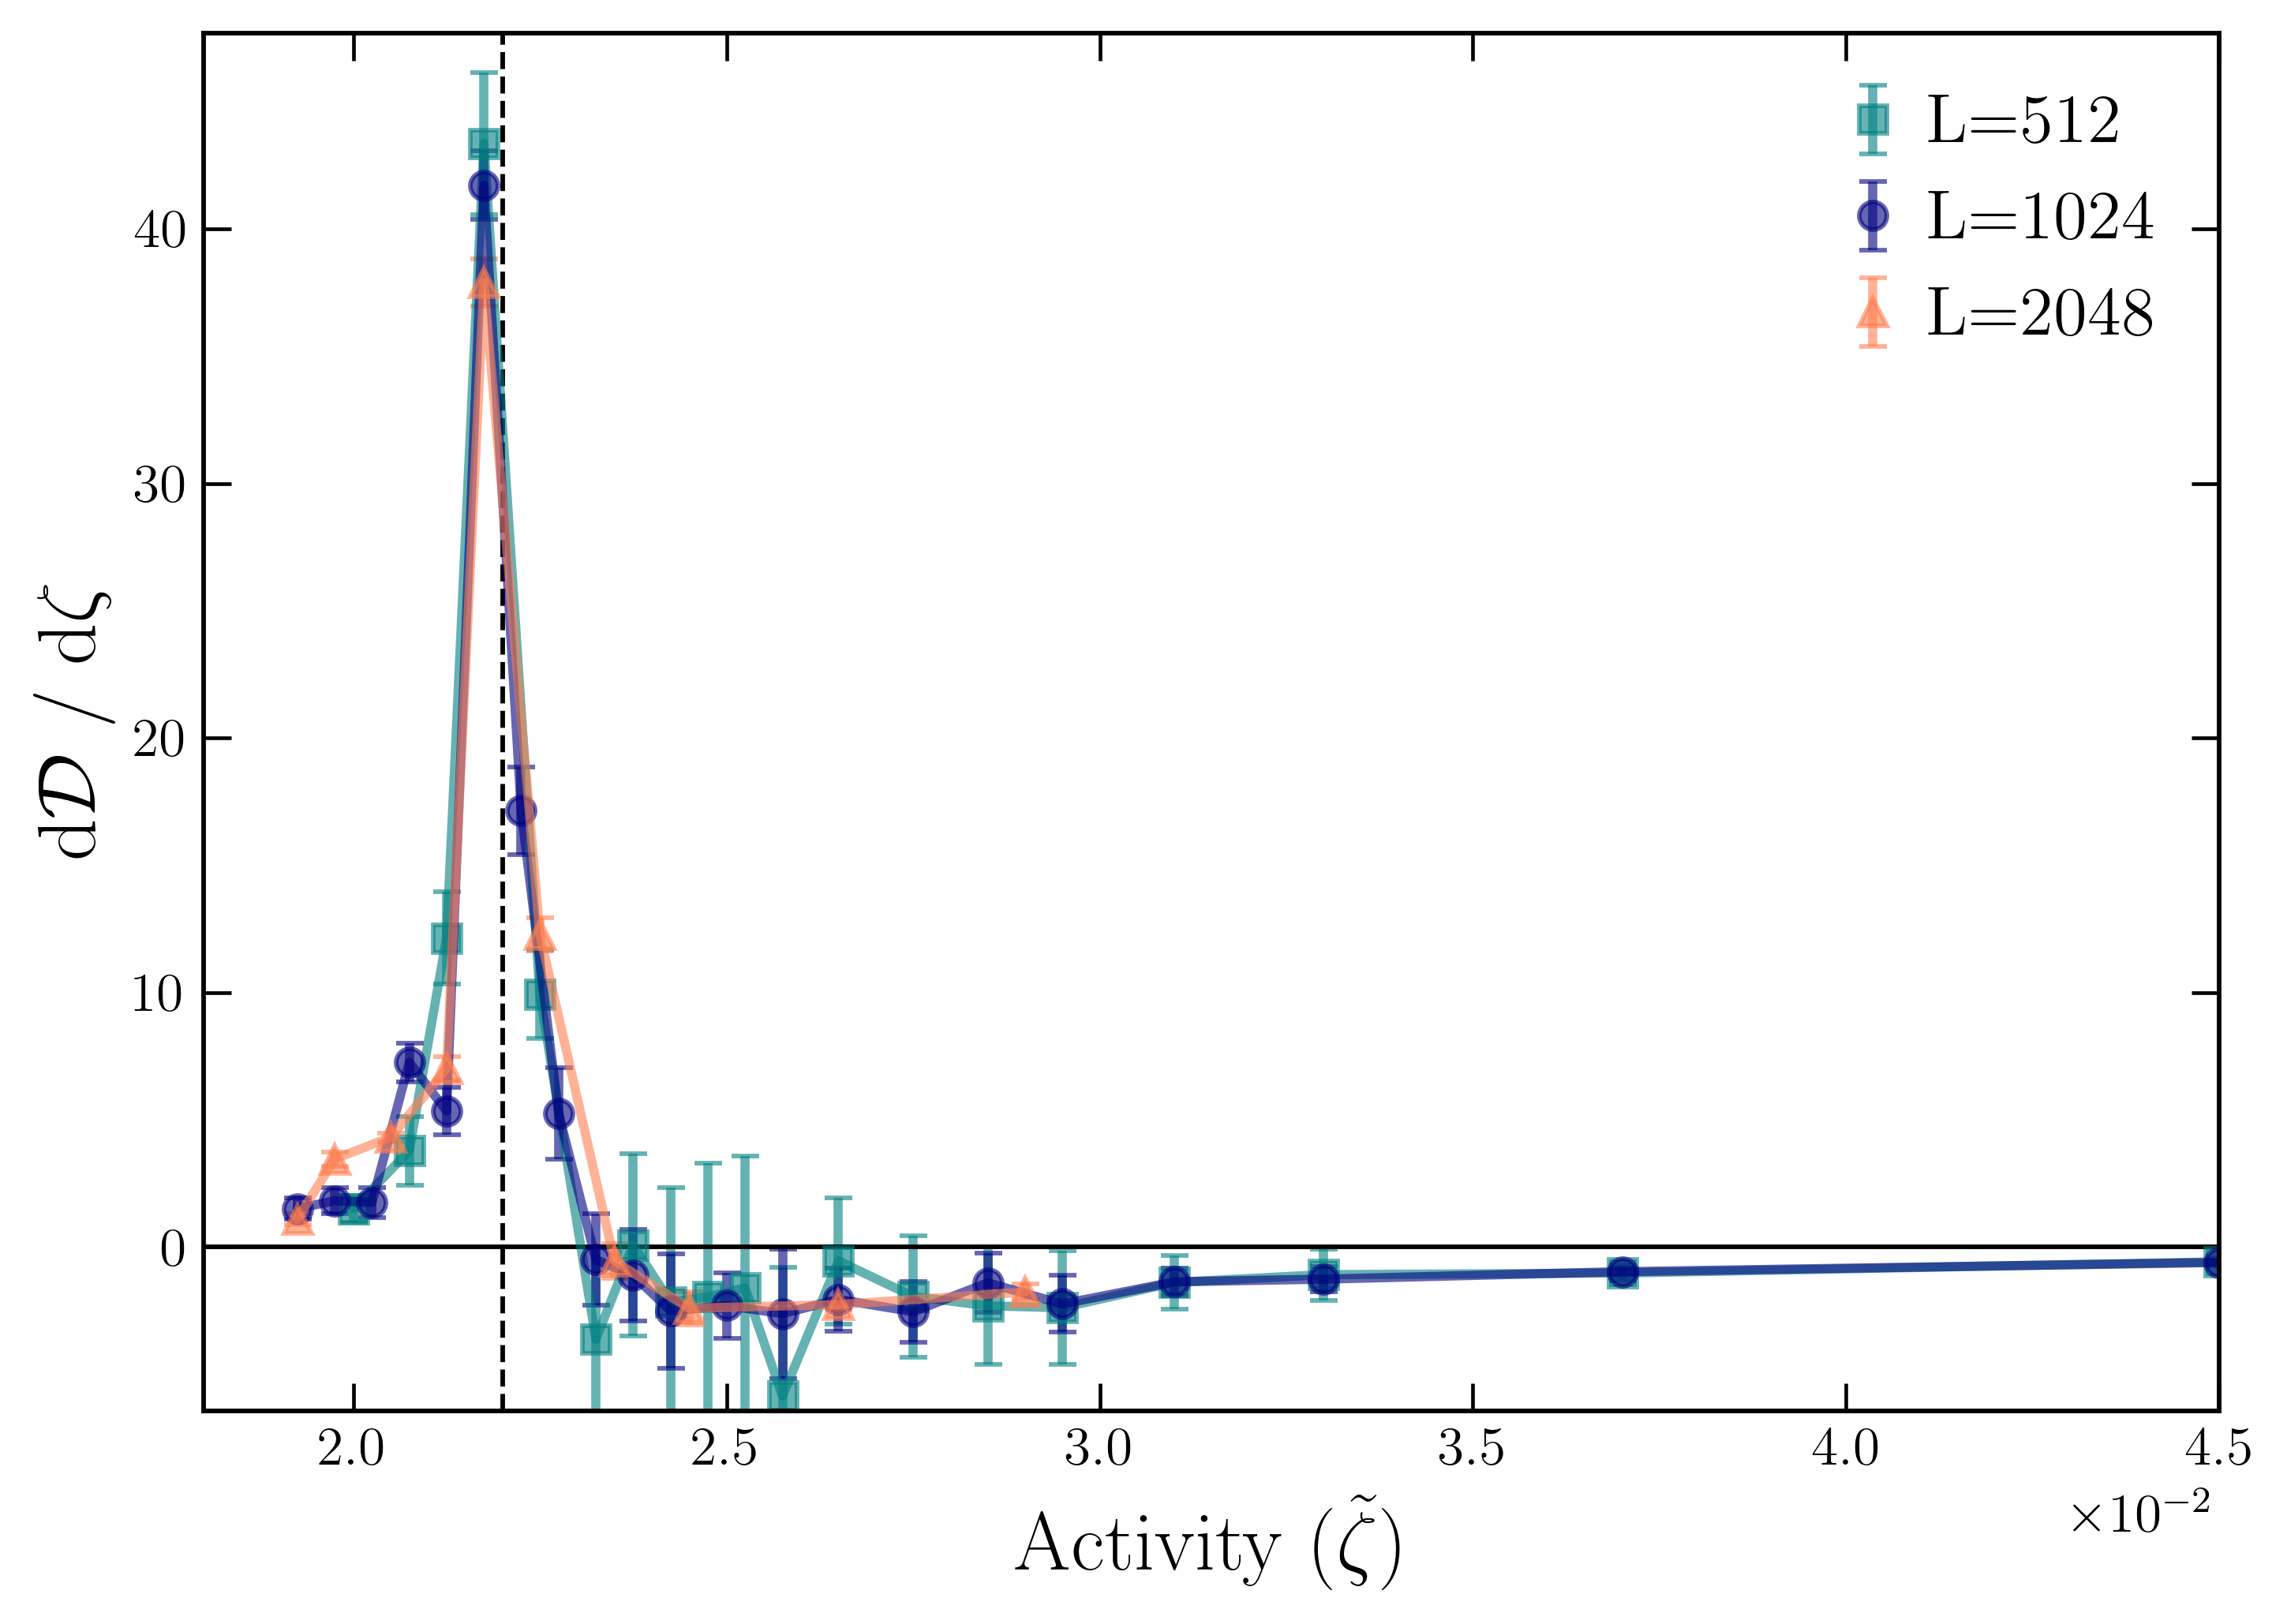

In [67]:
### Plot frac_deriv vs activity for different system sizes
fig, ax = plt.subplots(figsize=(7,5))
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
plot_abs = False

ymin, ymax = 0, 0

for i, LX in enumerate(L_list):
    act_list = act_dict[LX]
    cid_time_av = cid_time_av_dict[LX]
    cid_shuffle_time_av = cid_shuffle_time_av_dict[LX]
    cid_frac_time_av = frac_time_av_dict[LX]

    frac_diff = np.diff(1 - cid_frac_time_av[:, 0]) #
    act_diff = np.array(act_list[1:]) - np.array(act_list[:-1])
    act_diff_tot = np.array(act_list[:-1]) + act_diff/2
    deriv_frac = frac_diff / act_diff #np.diff(frac_av[:, 0]) / np.diff(act_list) #/ ada.LX[N]**2
    deriv_frac_err = np.sqrt(cid_frac_time_av[:, 1][1:]**2 + cid_frac_time_av[:,1][:-1]**2) / act_diff

    yvals = np.abs(deriv_frac) if plot_abs else deriv_frac
    ax.errorbar(act_diff_tot, yvals, yerr=deriv_frac_err, fmt=marker_shape[i], label=f'L={LX}', capsize=3, alpha=.6)

    ymin = min(ymin, np.nanmin(yvals))
    ymax = max(ymax, np.nanmax(yvals))

ax.vlines(0.022, ymin*1.1, ymax*1.1, color='k', linestyle='--', lw=1,)
ax.hlines(0, 0, .1, color='k', linestyle='-', lw=1,)
ax.set_xlim(0.018, 0.045)
ax.set_ylim(ymin*1.1, ymax*1.1)
ax.set_xlabel(r'Activity ($\tilde{\zeta}$)')
ax.set_ylabel(r'd$\mathcal{D}$ / d$\zeta$')
ax.legend(ncols=1, loc='upper right')

if save_figs:   
    fig.savefig(os.path.join(figs_save_path, f'ddiv.pdf'), bbox_inches='tight', dpi=620, pad_inches=.05)